<a href="https://colab.research.google.com/github/Hennakhan/Detecting-Islamophobia/blob/master/mBert_Hin_Imbalanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Islamophhobia Detection with BERT using Keras and TensorFlow 2

In [1]:
!nvidia-smi

Thu Oct  8 11:43:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow-gpu 

     |████████████████████████████████| 320.4MB 41kB/s 


In [3]:
!pip install --upgrade grpcio

Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.32.0)


In [4]:
!pip install tqdm

In [5]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 3.5MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.6-cp36-none-any.whl size=30318 sha256=307b8ecccc2c599d27fea1015b8566e987e30967bc7a568c05e5df88c982766a
  Stored in directory: /root/.cache/pip/wheels/07/a0/b4/75b0601ebaa41e517a797fe9cea119c789664c8408f8a74ae9
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=e72f4a3062a193deb03d221b30ccea18055a3e5b8020f3ed3d5f7c9e07e23986
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=d0da4ee7ee517eeeb73f8690a0253ae6ee96749e445f1f4c3c6b24731e49daec
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [6]:
!pip install googletrans

     |████████████████████████████████| 61kB 5.4MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 972kB 16.9MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
     |████████████████████████████████| 102kB 10.5MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp36-none-any.whl size=15736 sha256=9352b8d6da86683ff6c38b67881280db559b7db9cf6fc77793b4789b868f3291
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=bfffe77d1db2755c112aec282f39b05e50f3da2982ea8ca67fe1556d32463a25
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


In [7]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 9.1MB/s 


In [8]:
!pip install googletrans

In [9]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

import re

# translator
import googletrans
from googletrans import Translator

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Data


In [10]:
# Hindi data
!gdown --id 1EQRLvSUJn6VxFluTqNEGxXcV8_5OmCaW --output data-task3.csv

Downloading...
From: https://drive.google.com/uc?id=1EQRLvSUJn6VxFluTqNEGxXcV8_5OmCaW
To: /content/data-task3.csv
100% 1.63M/1.63M [00:00<00:00, 104MB/s]


In [11]:
df = pd.read_csv('data-task3.csv', 
                   delimiter=',')
df.columns = ['Text', 'Label']
df.head(15)
df["Text"] = df["Text"].astype(str)
df["Label"] = df["Label"].astype(str)

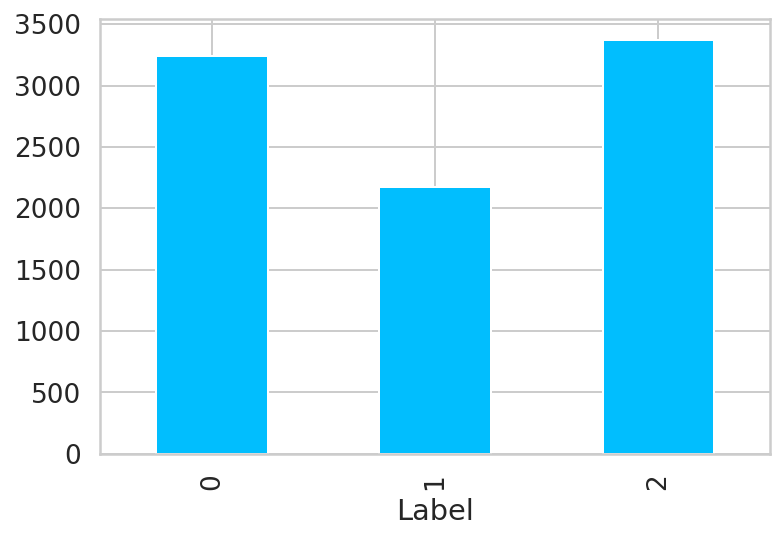

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [13]:

# For entire dataset sentences for each labels 
df.Label.value_counts()

2    3375
0    3244
1    2174
Name: Label, dtype: int64

In [14]:
df=df.sample(frac=1).reset_index(drop=True)
df

,Text,Label
0,'सुम्मा आमीन 💐💐💐💐 #डॉक्टर_कफील_की_रिहाई_मुबार...,1
1,'@RajkumarRatnap2 सहमत हूँ आपसे सर जी । रावण औ...,2
2,'@Munnasaifi @sardanarohit बेंगलुरु में आग किस...,2
3,'जो इस्लाम वज़ू में जायदा पानी बहाने का इजाजत...,0
4,'@GeoIntel2 दीवाली पे मिलो खींच खींच के बाल त...,0
...,...,...
8788,'तस्वीरों में देखें कैसे रांची के राजकुमार बन...,0
8789,'@ZeeNewsHindi हज़ारों मुसलमानों ने रमज़ान में...,1
8790,'@chandan_m_yadav @RustamPatel3 @nidhiyadavsp ...,0
8791,'@AbdullahJlp अल्लाह हाफ़िज़ भाई मेरे,1


Data Preprocessing

In [15]:
df = df[df.Text != '']

In [16]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.10, random_state=42)

In [17]:
df=df.sample(frac=1).reset_index(drop=True)

In [18]:
df.head()

,Text,Label
0,'@waglenikhil एक जिहादी दूसरे जिहादी का समर्थन...,2
1,जेहादी मानसिकता @SumanSh58122278 @kaur_ravindra,2
2,'@ajeetbharti ये दीवाली रूकनी नही चाहिये बस,0
3,Hindu politicians attending iftar party repres...,2
4,'@ShilpiSinghINC @rahatindori दो कौड़ी का जेहा...,2


# Islamophhobia Detection with BERT


In [19]:
!gdown --id 1ds0mgIfyRZ1vTdQCT4Q5EOxTFA1vH47a --output multi_cased_L-12_H-768_A-12.zip

Downloading...
From: https://drive.google.com/uc?id=1ds0mgIfyRZ1vTdQCT4Q5EOxTFA1vH47a
To: /content/multi_cased_L-12_H-768_A-12.zip
663MB [00:09, 71.4MB/s]


In [20]:
!unzip multi_cased_L-12_H-768_A-12

Archive:  multi_cased_L-12_H-768_A-12.zip
   creating: multi_cased_L-12_H-768_A-12/
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: multi_cased_L-12_H-768_A-12/vocab.txt  
  inflating: multi_cased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: multi_cased_L-12_H-768_A-12/bert_config.json  


In [21]:
os.makedirs("model", exist_ok=True)

In [22]:
!mv multi_cased_L-12_H-768_A-12/ model

In [23]:
bert_model_name="multi_cased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

In [24]:
class IslamophobiaDetectionData:
  DATA_COLUMN = "Text"
  LABEL_COLUMN = "Label"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IslamophobiaDetectionData.DATA_COLUMN], row[IslamophobiaDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [25]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [26]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  #print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)

  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)


  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
  
  model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)
        
  return model

## Training

In [ ]:
classes = train.Label.unique().tolist()

data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)

7913it [00:03, 2123.86it/s]
880it [00:00, 2158.10it/s]


max seq_len 167


In [ ]:
model = create_model(data.max_seq_len, bert_ckpt_file)

Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fcf0dafd550> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          177261312 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [ ]:
history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5
)

Epoch 1/5
446/446 [==============================] - 227s 510ms/step - loss: 0.7430 - acc: 0.7986 - val_loss: 0.6168 - val_acc: 0.9343
Epoch 2/5
446/446 [==============================] - 220s 493ms/step - loss: 0.6195 - acc: 0.9316 - val_loss: 0.6300 - val_acc: 0.9205
Epoch 3/5
446/446 [==============================] - 220s 494ms/step - loss: 0.6112 - acc: 0.9405 - val_loss: 0.6159 - val_acc: 0.9356
Epoch 4/5
446/446 [==============================] - 220s 493ms/step - loss: 0.6065 - acc: 0.9452 - val_loss: 0.6177 - val_acc: 0.9343
Epoch 5/5
446/446 [==============================] - 220s 494ms/step - loss: 0.6039 - acc: 0.9469 - val_loss: 0.6092 - val_acc: 0.9419


## Evaluation

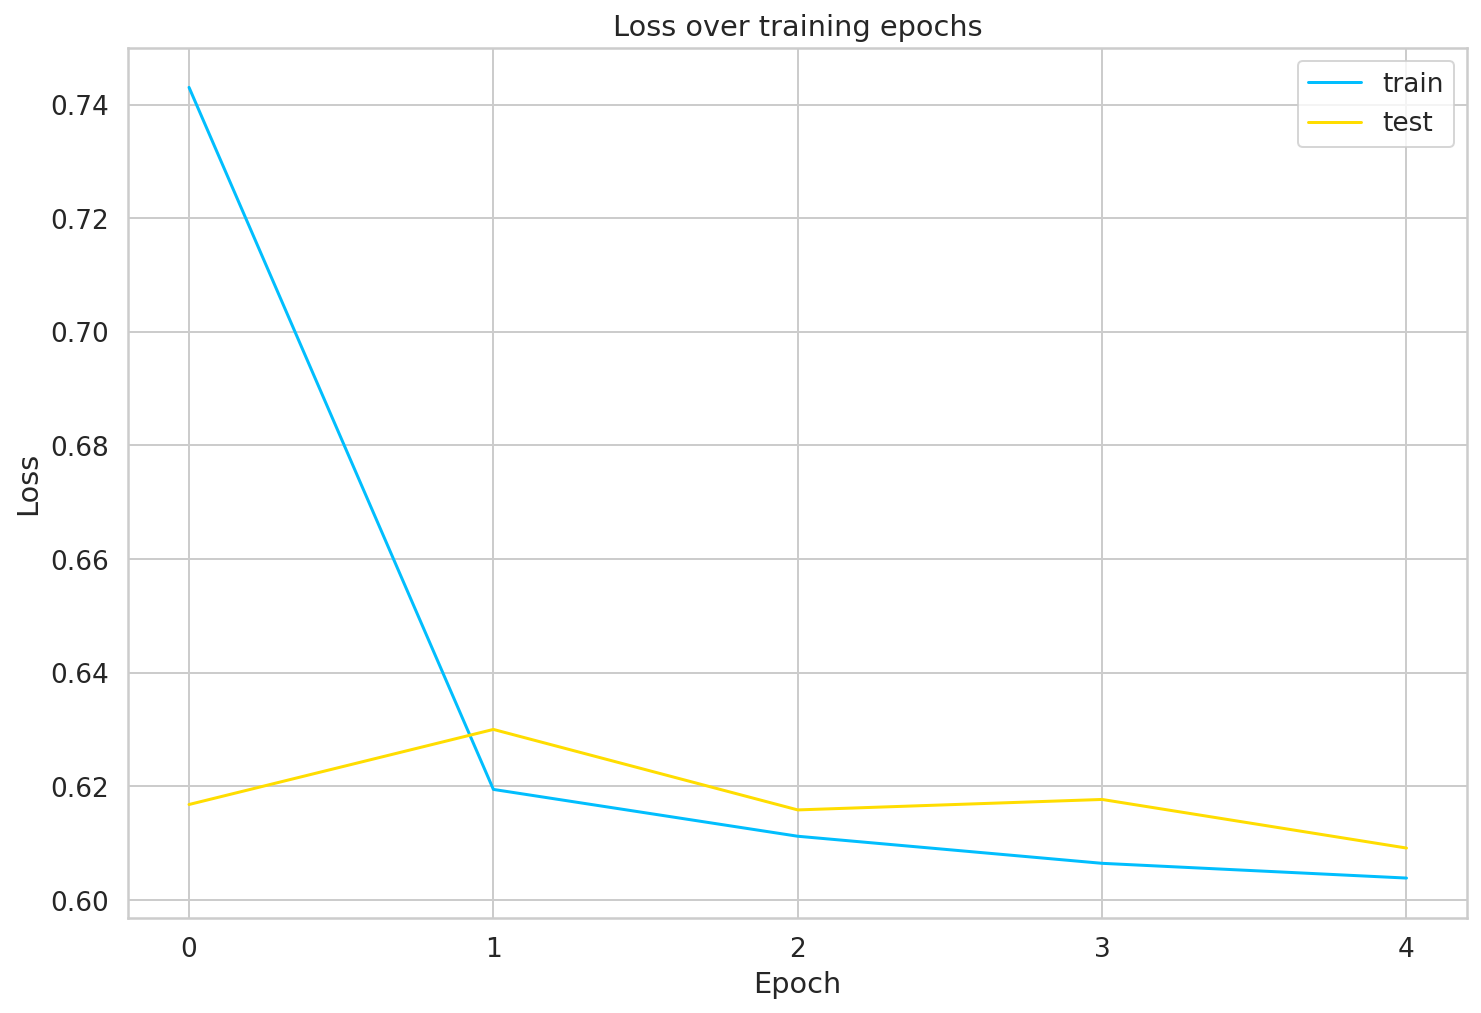

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

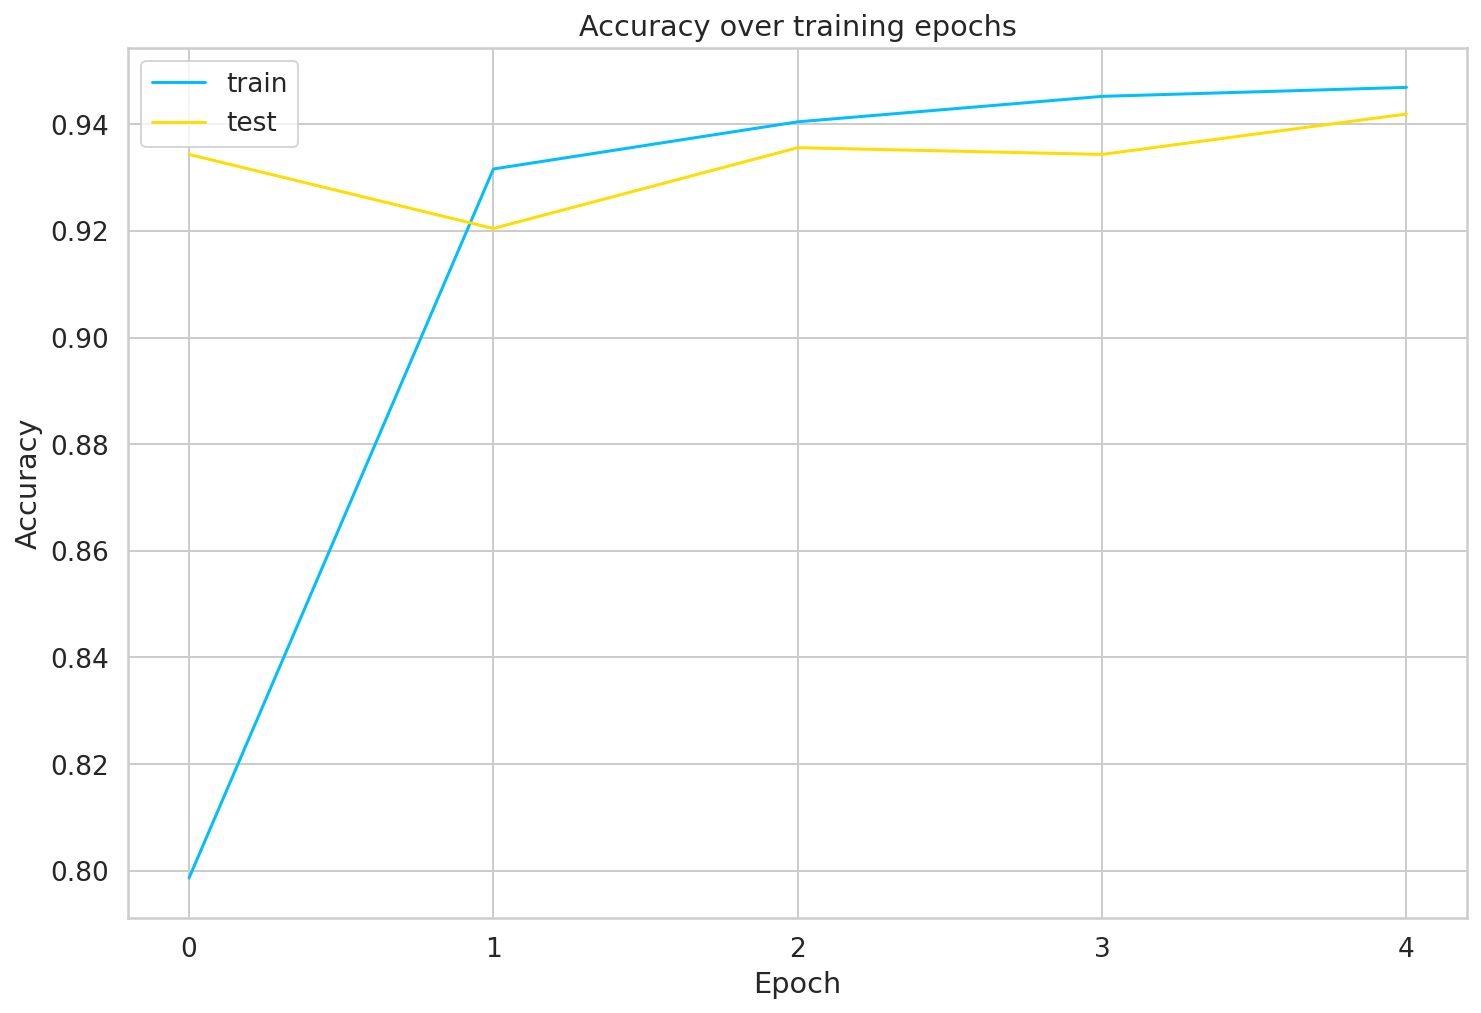

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [ ]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

28/28 [==============================] - 3s 103ms/step - loss: 0.6089 - acc: 0.9420
train acc 0.9536206126213074
test acc 0.9420454502105713


In [ ]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [ ]:
print(classification_report(data.test_y, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       327
           1       0.97      0.92      0.94       336
           2       0.89      0.95      0.92       217

    accuracy                           0.94       880
   macro avg       0.94      0.94      0.94       880
weighted avg       0.94      0.94      0.94       880



In [ ]:

cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

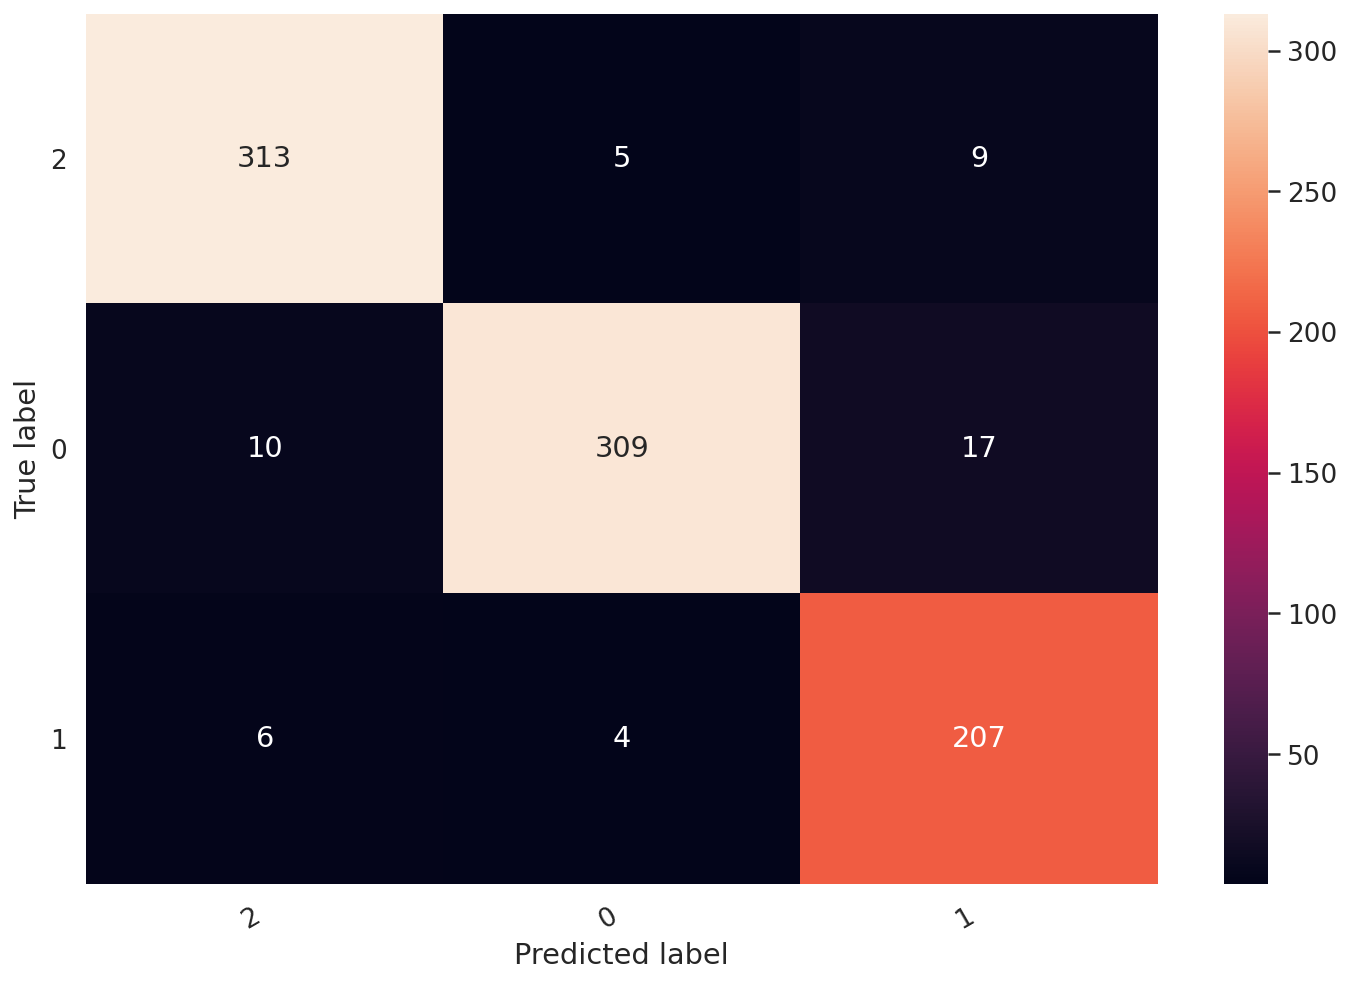

In [ ]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# 10 Fold cross validation

In [27]:
import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

kFold = 10

#To get accuracy of the model for 10 different splits
scores = []
training_accuracy = []
testing_accuracy = []
print("BERT: ")
for i in range(kFold):
    print('Fold ', i+1)
    print('')
    # Splitting data into test and train
    train, test = train_test_split(df, test_size=0.10, shuffle = True)

    classes = train.Label.unique().tolist()
    data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)
    model = create_model(data.max_seq_len, bert_ckpt_file)
    history = model.fit( x=data.train_x, y=data.train_y,validation_split=0.1,batch_size=16, shuffle=True,epochs=5)
    #train_loss, train_acc = model.evaluate(data.train_x, data.train_y)
    test_loss, test_acc = model.evaluate(data.test_x, data.test_y)
    
    #training_accuracy.append(train_acc)
    testing_accuracy.append(test_acc)

    y_pred = model.predict(data.test_x).argmax(axis=-1)

    scoreValue =accuracy_score(data.test_y, y_pred)
    scores.append(scoreValue)


233it [00:00, 2328.53it/s]

BERT: 
Fold  1



7913it [00:03, 2285.73it/s]
880it [00:00, 2361.11it/s]


max seq_len 167
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f7945f7ec88> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 233s 522ms/step - loss: 0.8244 - acc: 0.7037 - val_loss: 0.6169 - val_acc: 0.9331
Epoch 2/5
446/446 [==============================] - 224s 502ms/step - loss: 0.6172 - acc: 0.9334 - val_loss: 0.6067 - val_acc: 0.9444
Epoch 3/5
446/446 [==============================] - 224s 502ms/step - 

241it [00:00, 2407.73it/s]

Fold  2



7913it [00:03, 2381.16it/s]
880it [00:00, 2400.04it/s]


max seq_len 167
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f788103c4e0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 226s 508ms/step - loss: 0.8068 - acc: 0.7262 - val_loss: 0.6161 - val_acc: 0.9318
Epoch 2/5
446/446 [==============================] - 208s 465ms/step - loss: 0.6301 - acc: 0.9195 - val_loss: 0.6235 - val_acc: 0.9268
Epoch 3/5
446/446 [==============================] - 207s 464ms/step - 

236it [00:00, 2351.75it/s]

Fold  3



7913it [00:03, 2423.73it/s]
880it [00:00, 2473.36it/s]


max seq_len 167
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f76bb7eb0f0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 209s 468ms/step - loss: 0.7310 - acc: 0.8118 - val_loss: 0.6169 - val_acc: 0.9318
Epoch 2/5
446/446 [==============================] - 207s 464ms/step - loss: 0.6128 - acc: 0.9374 - val_loss: 0.6023 - val_acc: 0.9482
Epoch 3/5
446/446 [==============================] - 206s 461ms/step - 

222it [00:00, 2208.95it/s]

Fold  4



7913it [00:03, 2414.64it/s]
880it [00:00, 2338.97it/s]


max seq_len 167
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f78a25fbf98> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 217s 486ms/step - loss: 0.7256 - acc: 0.8169 - val_loss: 0.6072 - val_acc: 0.9381
Epoch 2/5
446/446 [==============================] - 208s 467ms/step - loss: 0.6093 - acc: 0.9423 - val_loss: 0.6166 - val_acc: 0.9356
Epoch 3/5
446/446 [==============================] - 203s 455ms/step - 

226it [00:00, 2258.54it/s]

Fold  5



7913it [00:03, 2309.31it/s]
880it [00:00, 2313.98it/s]


max seq_len 167
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f788164b0b8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 215s 483ms/step - loss: 0.7460 - acc: 0.7946 - val_loss: 0.6110 - val_acc: 0.9394
Epoch 2/5
446/446 [==============================] - 213s 478ms/step - loss: 0.6199 - acc: 0.9303 - val_loss: 0.6105 - val_acc: 0.9394
Epoch 3/5
446/446 [==============================] - 212s 475ms/step - 

243it [00:00, 2423.82it/s]

Fold  6



7913it [00:03, 2352.38it/s]
880it [00:00, 2384.81it/s]


max seq_len 167
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f78a39bbb38> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 215s 483ms/step - loss: 0.7761 - acc: 0.7564 - val_loss: 0.6209 - val_acc: 0.9306
Epoch 2/5
446/446 [==============================] - 211s 474ms/step - loss: 0.6086 - acc: 0.9427 - val_loss: 0.6157 - val_acc: 0.9343
Epoch 3/5
446/446 [==============================] - 210s 470ms/step - 

233it [00:00, 2327.11it/s]

Fold  7



7913it [00:03, 2324.30it/s]
880it [00:00, 2352.29it/s]


max seq_len 167
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f76b8267c88> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 215s 482ms/step - loss: 0.7519 - acc: 0.7856 - val_loss: 0.6153 - val_acc: 0.9356
Epoch 2/5
446/446 [==============================] - 203s 454ms/step - loss: 0.6216 - acc: 0.9285 - val_loss: 0.6245 - val_acc: 0.9255
Epoch 3/5
446/446 [==============================] - 203s 456ms/step - 

239it [00:00, 2389.49it/s]

Fold  8



7913it [00:03, 2346.62it/s]
880it [00:00, 2352.84it/s]


max seq_len 167
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f78a338a240> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 214s 480ms/step - loss: 0.8448 - acc: 0.6815 - val_loss: 0.6251 - val_acc: 0.9255
Epoch 2/5
446/446 [==============================] - 211s 472ms/step - loss: 0.6197 - acc: 0.9306 - val_loss: 0.6112 - val_acc: 0.9381
Epoch 3/5
446/446 [==============================] - 213s 477ms/step - 

245it [00:00, 2443.80it/s]

Fold  9



7913it [00:03, 2338.31it/s]
880it [00:00, 2323.41it/s]


max seq_len 167
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f75b481fe80> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 212s 474ms/step - loss: 0.8079 - acc: 0.7245 - val_loss: 0.6086 - val_acc: 0.9419
Epoch 2/5
446/446 [==============================] - 210s 470ms/step - loss: 0.6145 - acc: 0.9360 - val_loss: 0.6151 - val_acc: 0.9343
Epoch 3/5
446/446 [==============================] - 210s 471ms/step - 

240it [00:00, 2392.44it/s]

Fold  10



7913it [00:03, 2353.17it/s]
880it [00:00, 2352.98it/s]


max seq_len 167
Done loading 196 BERT weights from: model/multi_cased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f7881f92d68> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
446/446 [==============================] - 211s 472ms/step - loss: 0.7203 - acc: 0.8233 - val_loss: 0.6231 - val_acc: 0.9280
Epoch 2/5
446/446 [==============================] - 207s 464ms/step - loss: 0.6162 - acc: 0.9340 - val_loss: 0.5941 - val_acc: 0.9571
Epoch 3/5
446/446 [==============================] - 201s 451ms/step - 

In [28]:

Mean_score = sum(scores) / len(scores)
print(f" Mean predict: {Mean_score}" )

mean_test = sum(testing_accuracy)/len(testing_accuracy)
print(f" Mean testing accuracy for 10 folds: {mean_test}" )

 Mean predict: 0.9420454545454545
 Mean testing accuracy for 10 folds: 0.9420454502105713


In [ ]:

translator = Translator()
sentences = []
# 1
hin_text =  "इसलाम सुंदर है"

sentences.append(hin_text)

# 0
hin_text =  " समाज वादी  पार्टी  जिंदाबाद "

sentences.append(hin_text)

# 2
hin_text =  "'गाजा में दीवाली की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂"

sentences.append(hin_text)

# 2
hin_text = "जिहादी लोग"

sentences.append(hin_text)

# 2
sentences.append( "Play our song now you asshole jehadi muslim")

# 0
sentences.append( "Rate this book as awful")



pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nLabel:", classes[label])
  print()

text: इसलाम सुंदर है 
Label: 1

text:  समाज वादी  पार्टी  जिंदाबाद  
Label: 0

text: 'गाजा में दीवाली की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂 
Label: 0

text: जिहादी लोग 
Label: 2

text: Play our song now you asshole jehadi muslim 
Label: 2

text: Rate this book as awful 
Label: 2

